In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches
from scarches.models import tranVAE
from scarches.dataset import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
condition_key = 'study'
cell_type_key = 'cell_type'
target_conditions = []


tranvae_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [5]:
adata_all = sc.read(os.path.expanduser(f'~/Documents/benchmarking_datasets/mouse_brain_subsampled_normalized_hvg.h5ad'))
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)].copy()
target_adata = adata[adata.obs[condition_key].isin(target_conditions)].copy()
source_conditions = source_adata.obs[condition_key].unique().tolist()
source_labels = source_adata.obs[cell_type_key].unique().tolist()

In [6]:
tranvae = scarches.models.tranVAE(
    input_dim=source_adata.n_vars,
    conditions=source_conditions,
    cell_types=source_labels,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 4
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 4
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [7]:
tranvae.condition_encoder

{'Saunders': 0, 'Rosenberg': 1, 'Tabula_muris': 2, 'Zeisel': 3}

In [8]:
tranvae.cell_type_encoder

{'astrocyte': 0,
 'neuron': 1,
 'endothelial cell': 2,
 'oligodendrocyte': 3,
 'oligodendrocyte precursor cell': 4,
 'microglial cell': 5,
 'macrophage': 6,
 'brain pericyte': 7,
 'ependymal cell': 8,
 'olfactory ensheathing cell': 9}

In [9]:
sup_trainer = scarches.trainers.tranVAETrainer(
    model=tranvae,
    adata=source_adata,
    condition_key=condition_key,
    cell_type_key=cell_type_key,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=1000,
    tau=0,
)

In [10]:
sup_trainer.train(
    n_epochs=tranvae_epochs,
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


LOSS: tensor(11.489, device='cuda:0')
ACCURACY: tensor(0.265, device='cuda:0')
 |█-------------------| 8.2%  - epoch_loss: 4562.88 - epoch_recon_loss: 4537.78 - epoch_kl_loss:   42.03 - epoch_landmark_loss:    0.02 - epoch_landmark_accuracy_loss:    0.93 - val_loss: 1762.34 - val_recon_loss: 1746.82 - val_kl_loss:   42.12 - val_landmark_loss:    0.01 - val_landmark_accuracy_loss:    0.94949493
ADJUSTED LR
 |██------------------| 11.4%  - epoch_loss: 4534.26 - epoch_recon_loss: 4509.01 - epoch_kl_loss:   42.05 - epoch_landmark_loss:    0.01 - epoch_landmark_accuracy_loss:    0.93 - val_loss: 1765.77 - val_recon_loss: 1748.34 - val_kl_loss:   42.10 - val_landmark_loss:    0.01 - val_landmark_accuracy_loss:    0.95
ADJUSTED LR
 |██------------------| 12.8%  - epoch_loss: 4517.77 - epoch_recon_loss: 4491.51 - epoch_kl_loss:   42.05 - epoch_landmark_loss:    0.01 - epoch_landmark_accuracy_loss:    0.93 - val_loss: 1764.16 - val_recon_loss: 1745.35 - val_kl_loss:   42.10 - val_landmark_loss:

In [12]:
ref_path = 'tranvae_model_brain'
torch.save(tranvae.state_dict(),ref_path)

In [15]:
device = next(tranvae.parameters()).device
x = torch.tensor(source_adata.X, device=device)
c = np.asarray(source_adata.obs[condition_key])
labels = np.zeros(c.shape[0])
for condition, label in tranvae.condition_encoder.items():
    labels[c == condition] = label
c = torch.tensor(labels, device=device)

In [17]:
latents = []
indices = torch.arange(x.size(0), device=device)
subsampled_indices = indices.split(512)
for batch in subsampled_indices:
    latent = tranvae.get_latent(x[batch,:], c[batch])
    latents += [latent.cpu().detach()]
latent = np.array(torch.cat(latents))

In [18]:
adata_latent = sc.AnnData(latent)
adata_latent.obs['celltype'] = source_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()
adata_latent.write_h5ad(filename='tranvae_brain.h5ad')

... storing 'celltype' as categorical
... storing 'batch' as categorical


[<AxesSubplot:title={'center':'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>]

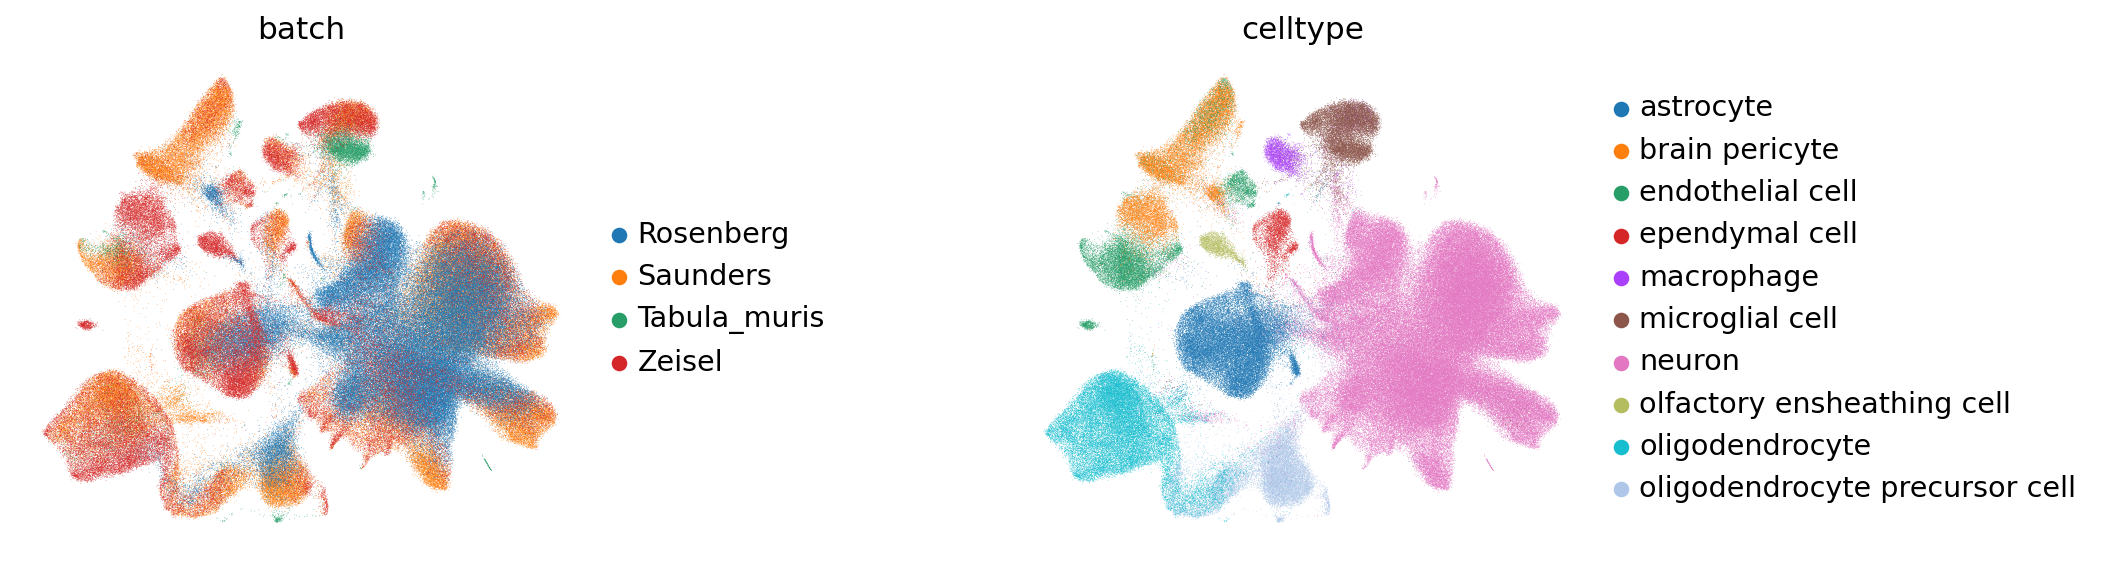

In [19]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'celltype'],
           frameon=False,
           wspace=0.6,
           show=False
           )

In [20]:
landmarks = sup_trainer.landmarks.cpu().numpy()
landmarks

array([[ 0.17, -0.19, -0.84,  0.18, -0.1 ,  0.21, -0.67,  0.14, -0.52,
        -0.73],
       [ 0.15, -0.14, -0.86,  0.23, -0.09,  0.27, -0.67,  0.04, -0.47,
        -0.75],
       [ 0.11, -0.23, -0.83,  0.18,  0.01,  0.29, -0.66,  0.05, -0.53,
        -0.67],
       [ 0.13, -0.18, -0.85,  0.16, -0.01,  0.27, -0.64,  0.14, -0.38,
        -0.66],
       [ 0.1 , -0.14, -0.86,  0.15, -0.1 ,  0.23, -0.7 ,  0.1 , -0.44,
        -0.68],
       [ 0.21, -0.14, -0.77,  0.19, -0.03,  0.33, -0.76,  0.07, -0.48,
        -0.69],
       [ 0.21, -0.2 , -0.81,  0.14, -0.03,  0.32, -0.77,  0.09, -0.48,
        -0.66],
       [ 0.07, -0.2 , -0.88,  0.17, -0.01,  0.31, -0.67,  0.06, -0.56,
        -0.67],
       [ 0.16, -0.23, -0.88,  0.22, -0.16,  0.36, -0.7 ,  0.15, -0.56,
        -0.75],
       [ 0.07, -0.2 , -0.82,  0.24, -0.06,  0.22, -0.71,  0.21, -0.49,
        -0.66]], dtype=float32)

In [21]:
extended_latent = adata_latent.X.copy()
extended_latent = np.concatenate((extended_latent, landmarks), axis=0)

extended_latent_labels = adata_latent.obs['celltype'].tolist()
landmark_names=[]
for i in range(landmarks.shape[0]):
    landmark_names.append(f'Landmark{i}')
extended_latent_labels+=landmark_names
    
extended_latent_batches = adata_latent.obs['batch'].tolist()
extended_latent_batches += landmarks.shape[0]*['Landmarks']

extended_latent = sc.AnnData(extended_latent)
extended_latent.obs['celltype'] = extended_latent_labels
extended_latent.obs['batch'] = extended_latent_batches
extended_latent

AnnData object with n_obs × n_vars = 332139 × 10
    obs: 'celltype', 'batch'

In [22]:
sc.pp.neighbors(extended_latent, n_neighbors=8)
sc.tl.leiden(extended_latent)
sc.tl.umap(extended_latent)

... storing 'celltype' as categorical
... storing 'batch' as categorical


<AxesSubplot:title={'center':'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>

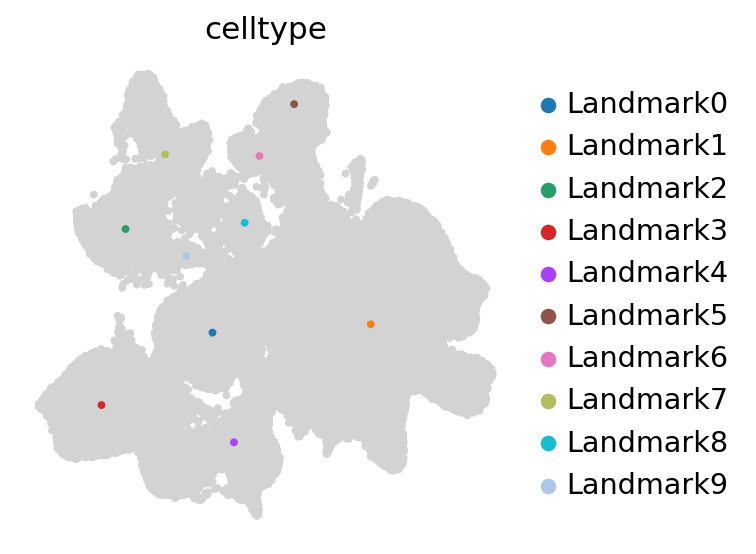

In [23]:
sc.pl.umap(extended_latent,
           color=['celltype'],
           groups=landmark_names,
           frameon=False,
           wspace=0.6,
           show=False,
           size=50
           )

<AxesSubplot:title={'center':'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>

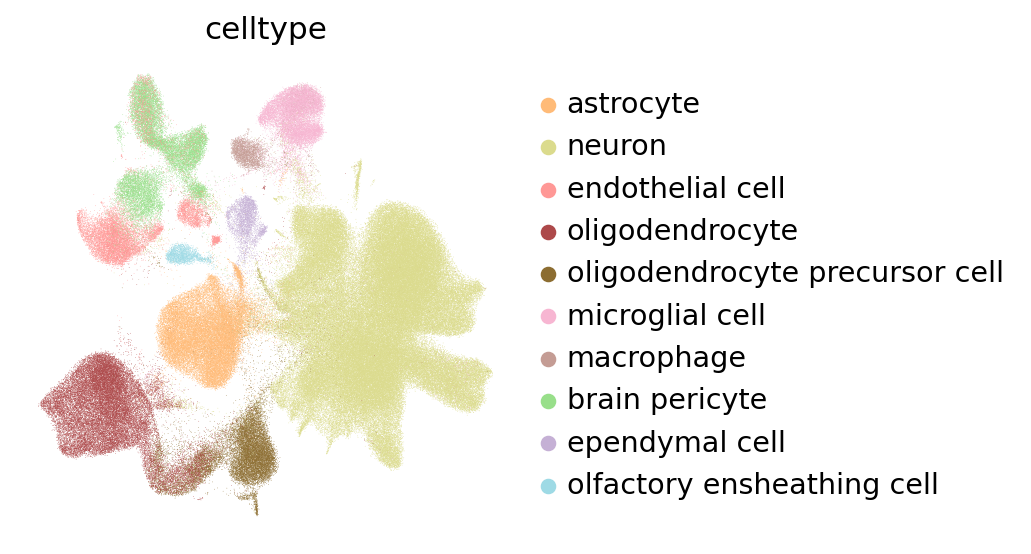

In [24]:
sc.pl.umap(extended_latent,
           color=['celltype'],
           frameon=False,
           groups=source_labels,
           wspace=0.6,
           show=False
           )